# Detectron2 Car Damage Detection
* 基於 https://www.kaggle.com/lplenka/detectron2-car-damage-detection

In [1]:
import os
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

cfg = get_cfg()

In [2]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("car_dataset_train",)
# cfg.DATASETS.TEST = ("car_dataset_val",)
# cfg.DATALOADER.NUM_WORKERS = 4
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") # Let training initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 4
# cfg.SOLVER.BASE_LR = 0.001 # pick a good LR
# cfg.SOLVER.WARMUP_ITERS = 800
# cfg.SOLVER.MAX_ITER = 1600 #adjust up if val mAP is still rising, adjust down if overfit
# cfg.SOLVER.STEPS = (600, 1550)
# cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 # faster, and good enough for this dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.RETINANET.NUM_CLASSES = 1
# cfg.TEST.EVAL_PERIOD = 600

In [3]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold for this model
cfg.DATASETS.TEST = ("car_dataset_val", )
predictor = DefaultPredictor(cfg)

In [4]:
dataset_dir = "input/coco-car-damage-detection-dataset"
img_dir = "img/"
train_dir = "train/"
val_dir = "val/"

from detectron2.data.datasets import register_coco_instances
register_coco_instances("car_dataset_train", {}, os.path.join(dataset_dir,train_dir,"COCO_train_annos.json"), os.path.join(dataset_dir,img_dir))
register_coco_instances("car_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_val_annos.json"), os.path.join(dataset_dir,img_dir))

In [5]:
from detectron2.data import MetadataCatalog, DatasetCatalog
val_dataset_dicts = DatasetCatalog.get("car_dataset_val")
val_metadata_dicts = MetadataCatalog.get("car_dataset_val")

In [6]:
import matplotlib.pyplot as plt
import random
import skimage.io as io
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

/home/appuser/.local/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/appuser/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


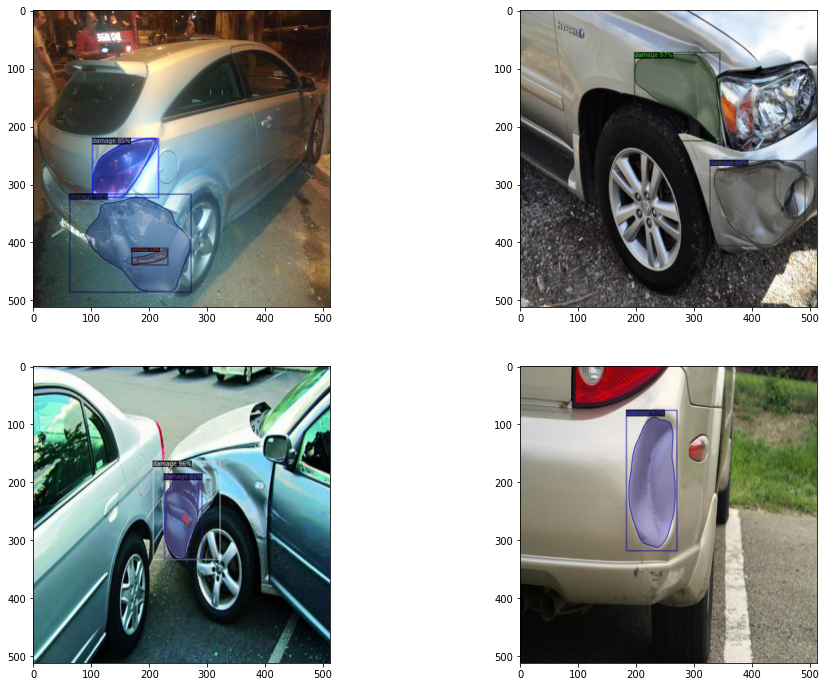

In [7]:
fig, ax = plt.subplots(2, 2, figsize =(16,12))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
for d in random.sample(val_dataset_dicts, 4):
    i=i+1    
    im = io.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata_dicts, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])